In [36]:
import numpy as np
import pandas as pd
from rdkit import Chem
import datamol as dm
from tqdm import tqdm
import os
from chembl_structure_pipeline import standardizer
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors

from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True

In [37]:
root = "."
compounds = pd.read_csv(os.path.join(root, "..", "config", "chembl_processed", "compound_info.csv"))
SMILES = compounds['canonical_smiles']

In [38]:
def get_canonical_smiles_datamol(smiles):
    mol = dm.to_mol(smiles)
    if not mol:
        return None
    mol = dm.fix_mol(mol)
    mol = dm.sanitize_mol(mol)
    if not mol:
        return None
    smi = dm.to_smiles(mol)
    if not smi:
        return None
    m2 = Chem.MolFromSmiles(smi)
    if not m2:
        return None
    return Chem.MolToSmiles(m2, canonical=True, isomericSmiles=True)

def get_canonical_smiles_rdkit(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None
    return Chem.MolToSmiles(mol, canonical=True, isomericSmiles=True)

def get_canonical_smiles(smiles):
    smiles = str(smiles).strip()
    try:
        canonical_smiles = get_canonical_smiles_datamol(smiles)
        if canonical_smiles:
            return canonical_smiles
    except Exception:
        pass
    try:
        return get_canonical_smiles_rdkit(smiles)
    except Exception:
        return None
    
def get_standardized_smiles(smiles):
    if not smiles:
        return None
    m = Chem.MolFromSmiles(smiles)
    if not m:
        return None
    m = standardizer.standardize_mol(m)
    m, _ = standardizer.get_parent_mol(m)
    if not m:
        return None
    m = standardizer.standardize_mol(m)
    if not m:
        return None
    return Chem.MolToSmiles(m, canonical=True, isomericSmiles=True)

def deal_with_nones(string):
    if string is None:
        return ""
    return string

def calculate_mw(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None
    mw = Descriptors.MolWt(mol)
    return str(round(mw, 3))



In [39]:
OUTPUT = []

for smiles in tqdm(SMILES[:10_000]):

    # Get canonical SMILES
    canonical_smiles = get_canonical_smiles(smiles)

    # Get standardized SMILES
    standardized_smiles = get_standardized_smiles(canonical_smiles)

    # Calculate mw
    mw = calculate_mw(standardized_smiles)

    # Deal with None's
    canonical_smiles = deal_with_nones(canonical_smiles)
    standardized_smiles = deal_with_nones(standardized_smiles)
    mw = deal_with_nones(mw)

    # Store results
    OUTPUT.append([standardized_smiles, mw])

OUTPUT = pd.DataFrame(OUTPUT, columns=["standardized_smiles", 'standardized_MW'])

  0%|          | 0/10000 [00:00<?, ?it/s][17:34:30] WARNING: not removing hydrogen atom without neighbors
[17:34:30] Running Normalizer
[17:34:30] Running Uncharger
[17:34:30] Running Uncharger
[17:34:30] Running Uncharger
[17:34:30] Running Normalizer
[17:34:30] Running Uncharger
[17:34:30] WARNING: not removing hydrogen atom without neighbors
[17:34:30] Running Normalizer
[17:34:30] Running Uncharger
[17:34:30] Running Uncharger
[17:34:30] Running Uncharger
[17:34:30] Running Normalizer
[17:34:30] Running Uncharger
[17:34:30] WARNING: not removing hydrogen atom without neighbors
[17:34:30] Running Normalizer
[17:34:30] Running Uncharger
[17:34:30] Running Uncharger
[17:34:30] Running Uncharger
[17:34:30] Running Normalizer
[17:34:30] Running Uncharger
[17:34:30] WARNING: not removing hydrogen atom without neighbors
[17:34:30] Running Normalizer
[17:34:30] Running Uncharger
[17:34:30] Running Uncharger
[17:34:30] Running Uncharger
[17:34:30] Running Normalizer
[17:34:30] Running Uncha

In [40]:
compounds['standardized_smiles'] = OUTPUT['standardized_smiles'].tolist() + [np.nan] * (len(compounds) - len(OUTPUT))
compounds['standardized_MW'] = OUTPUT['standardized_MW'].tolist() + [np.nan] * (len(compounds) - len(OUTPUT))
compounds['standardized_MW'] = compounds['standardized_MW'].astype(float)

In [43]:
compounds[compounds['standardized_MW'] != compounds['MW']][:10]

,molregno,standard_inchi,standard_inchi_key,canonical_smiles,chembl_id,MW,standardized_smiles,standardized_MW
163,189,InChI=1S/C10H12N4O5.ClH/c11-8(9(15)16)5-12-10(...,KPKQOLNYYNTYFV-QRPNPIFTSA-N,Cl.N[C@@H](CNC(=O)Nc1ccc([N+](=O)[O-])cc1)C(=O)O,CHEMBL263074,304.690,N[C@@H](CNC(=O)Nc1ccc([N+](=O)[O-])cc1)C(=O)O,268.229
164,190,InChI=1S/C11H13N3O6.ClH/c1-19-10(15)9(12)6-20-...,XXDDRLCOWXFJBD-FVGYRXGTSA-N,COC(=O)[C@@H](N)COC(=O)Nc1ccc([N+](=O)[O-])cc1.Cl,CHEMBL6267,319.701,COC(=O)[C@@H](N)COC(=O)Nc1ccc([N+](=O)[O-])cc1,283.240
165,191,InChI=1S/C12H15N3O5.ClH/c1-20-12(17)10(13)6-7-...,CHFLGKQWUSPWSQ-PPHPATTJSA-N,COC(=O)[C@@H](N)CCC(=O)Nc1ccc([N+](=O)[O-])cc1.Cl,CHEMBL6285,317.729,COC(=O)[C@@H](N)CCC(=O)Nc1ccc([N+](=O)[O-])cc1,281.268
173,199,InChI=1S/C11H14N4O5.ClH/c1-20-10(16)9(12)6-13-...,AEBBOZYZDNRCHF-FVGYRXGTSA-N,COC(=O)[C@@H](N)CNC(=O)Nc1ccc([N+](=O)[O-])cc1.Cl,CHEMBL6300,318.717,COC(=O)[C@@H](N)CNC(=O)Nc1ccc([N+](=O)[O-])cc1,282.256
394,463,InChI=1S/C10H10N2O5S.Na/c1-10(3-2-4-11)8(9(14)...,DRNHQKOSAXWVCX-LSTOSFGNSA-M,C[C@]1(/C=C/C#N)[C@H](C(=O)[O-])N2C(=O)C[C@H]2...,CHEMBL6461,292.248,C[C@]1(/C=C/C#N)[C@H](C(=O)O)N2C(=O)C[C@H]2S1(...,270.266
467,551,InChI=1S/C11H14N4O6S.Na/c1-11(5-14-3-2-12-13-1...,QBBWHSLAOSOQME-ZYEZBUCFSA-M,C[C@]1(Cn2ccnn2)[C@H](C(=O)[O-])N2C(=O)[C@@H](...,CHEMBL6533,352.304,C[C@]1(Cn2ccnn2)[C@H](C(=O)O)N2C(=O)[C@@H](CO)...,330.322
473,558,InChI=1S/C11H12N2O6S.Na/c1-11(3-2-4-12)7(10(16...,QXEYKECJAQHXEF-FCHKYLNPSA-M,C[C@]1(/C=C\C#N)[C@H](C(=O)[O-])N2C(=O)[C@@H](...,CHEMBL6469,322.274,C[C@]1(/C=C\C#N)[C@H](C(=O)O)N2C(=O)[C@@H](CO)...,300.292
474,559,InChI=1S/C11H12N2O6S.Na/c1-11(3-2-4-12)7(10(16...,QXEYKECJAQHXEF-KLZLNBGNSA-M,C[C@]1(/C=C/C#N)[C@H](C(=O)[O-])N2C(=O)[C@@H](...,CHEMBL269471,322.274,C[C@]1(/C=C/C#N)[C@H](C(=O)O)N2C(=O)[C@@H](CO)...,300.292
491,577,InChI=1S/C10H14N2O7S.Na/c1-10(4-11-19-2)6(9(15...,RRLPWVAOADJVLF-UEDLQCFHSA-M,CO/N=C/[C@@]1(C)[C@H](C(=O)[O-])N2C(=O)[C@@H](...,CHEMBL6678,328.278,CO/N=C/[C@@]1(C)[C@H](C(=O)O)N2C(=O)[C@@H](CO)...,306.296
671,782,"InChI=1S/C19H24NO5.BrH/c1-20(2,3)9-5-10-23-12-...",SKTSZSCUJGHYBI-UHFFFAOYSA-M,COc1c2occc2c(COCCC[N+](C)(C)C)c2ccc(=O)oc12.[Br-],CHEMBL6945,426.307,COc1c2occc2c(COCCC[N+](C)(C)C)c2ccc(=O)oc12,346.403


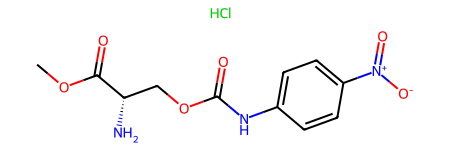

In [34]:
Chem.MolFromSmiles("COC(=O)[C@@H](N)COC(=O)Nc1ccc([N+](=O)[O-])cc1.Cl")

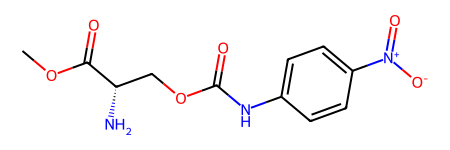

In [35]:
Chem.MolFromSmiles("COC(=O)[C@@H](N)COC(=O)Nc1ccc([N+](=O)[O-])cc1")